In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import gif
# from IPython.display import Image
from random import random
# For plotting Gaussian contours
from plotting_util import plot_gaussian_from_points
from plotting_util import plot_gaussian_from_parameters
import pandas as pd

### Gibbs sampler

We will first code a Gibbs Sampler for the model where $y=(y_1,\dots,y_n)$ are independent $\mathcal{N}(\mu,
\tau^{-1})$ random variables with both $\mu$ and $\tau$ unknown.

We will assign the $\mathcal{N}(0,\omega^{-1})$ prior on $\mu$ and the $Gamma(\alpha,\beta)$ prior on $\tau$.

In the Gibbs sampling procedure there will be two full conditional distributions that we will want to sample from, i.e., $p(\mu \mid y,\tau)$ and $p(\tau \mid y,\mu)$. First, prove manually

$$
\mu |y,\tau \sim \mathcal{N}\left(\frac{\tau}{n\tau + \omega}\sum y_{i},\frac{1}{n\tau + \omega}\right)
$$
and
$$
\tau|y,\mu \sim Gamma \left(\alpha + \frac{n}{2}, \beta+\frac{1}{2}\sum (y_{i}-\mu)^{2}\right)
$$


In [14]:
#Simulate data to check the Gibbs sampler
n = 100 #sample size
sigma_true = 2
sigma2_true = sigma_true**2
mu_true = 5
np.random.seed(5)
y = mu_true + np.random.randn(n)*sigma_true
ybar = np.mean(y)
S2 = np.sum((y-ybar)**2)

print('sample mean:',ybar)
print('sample variance:',S2/(n-1))

sample mean: 5.183093287735553
sample variance: 3.5018893815353676


Implement the Gibbs sampler in the following cell and check posterior traceplots of mean and variance and compare them with true values.

In [15]:

def SampleFromCond_mu(y, tau, w, n):
    # input: y, tau and w and num_sample
    # output: mu|y,tau
    # demension: 1*1
    mean_new = (tau/(n*tau+w))*sum(y)
    sigma_new = 1/(n*tau+w)
    mu_new = np.random.normal(mean_new, np.sqrt(sigma_new), 1)
    return mu_new

def SampleFromCond_tao(alpha, beta, n, y, mu):
    # input: alpha, beta, num_sample, y and mu
    # output: tao|y,mu
    # demension: 1*1
    first_arg = alpha+n/2
    second_arg = beta+0.5*sum((y-mu)**2)
    tau_new = np.random.gamma(first_arg, second_arg, 1)
    return tau_new



def GibbsSampling(initial_point, y, w, alpha, beta, num_samples):
    # input: initial points for mu and tau, alpha, beta, w, number of samples and y
    # output: 
    mu = np.zeros((num_samples,1))
    tau = np.zeros((num_samples,1))
    mu[0] = initial_point[0]
    tau[0] = initial_point[1]
    samples = np.zeros((num_samples,2))
    samples[0,0] = initial_point[0]
    samples[0,1] = initial_point[1]
    
    for i in range(num_samples-1):
        #Sample new mu conditioned on previous tau
        mu[i+1] = SampleFromCond_mu(y, tau[i], w, num_samples)
        
        #Sample new tau conditioned on previous mu and plot 
        tau[i+1] = SampleFromCond_tao(alpha, beta, num_samples, y, mu[i+1])


    return mu, tau
        

In [16]:
initial_point = [0, 0]
w = 1
alpha = 2
beta = 2

vec_mu, vec_tau = GibbsSampling(initial_point, y, w, alpha, beta, num_samples=n)
mu = np.mean(vec_mu)
var = np.sum((y-mu)**2)/(n-1)

In [17]:
# print(mu)
print(var)

3.511176217478169


Repeat for the model below

$$
y_i\sim \text{Poisson}(\mu), \;\;i=1,...,N,
$$
with priors 
$$
\mu \sim \text{Gamma}(2,\beta),\;\;
\beta \sim \text{Exponential}(1)
$$


$$
\mu| y,\beta \;\sim\;\text{Gamma}(2 + \sum_i y_i,n+\beta)
$$
$$
\beta|y,\mu\;\sim \;\text{Gamma}(3,1+\mu)
$$

In [18]:
def SampleFromCond_mu_(y, beta, n):
    # output: mu|y,tau
    # demension: 1*1
    first_arg = 2+sum(y)
    second_arg = n+beta
    mu_new = np.random.gamma(first_arg, second_arg,1)
    return mu_new

def SampleFromCond_beta(mu):
    # output: tao|y,mu
    # demension: 1*1
    first_arg = 3
    second_arg = 1+mu
    beta_new = np.random.gamma(first_arg, second_arg, 1)
    return beta_new



def GibbsSampling_(initial_point, y, mu, b, num_samples):
    # input: initial points for mu and tau, alpha, beta, w, number of samples and y
    # output: 
    mu = np.zeros((num_samples,1))
    beta = np.zeros((num_samples,1))
    mu[0] = initial_point[0]
    beta[0] = initial_point[1]
    samples = np.zeros((num_samples,2))
    samples[0,0] = initial_point[0]
    samples[0,1] = initial_point[1]
    
    for i in range(num_samples-1):
        #Sample new mu conditioned on previous tau
        mu[i+1] = SampleFromCond_mu_(y, b, n)
        
        #Sample new tau conditioned on previous mu and plot 
        beta[i+1] = SampleFromCond_beta(mu[i+1])


    return mu, beta

In [33]:
n = 100 #sample size

mu_true = 10
np.random.seed(3)
y = np.random.poisson(mu_true,n)



b = np.random.exponential(1,1)
mu = np.random.gamma(2,b,1)

vec_mu, vec_beta = GibbsSampling_(initial_point, y, mu, b, num_samples=n)

mu = np.mean(vec_mu)
var = np.sum((y-mu)**2)/(n-1)
mu,var

(98463.83340320522, 9791089880.443878)

### Mean Field approximation 

We will first simulate $100$ independent observations from the model 

$$
y\sim N(\mu, \tau^{-1})
$$

with $\mu=5$ and $\tau^{-1}=0.5$.

Treat $\mu$ and $\tau^{-1}$ as unknown and  use the mean field approximation algorithm presented in the lecture to estimate them.

#### Simulate Data

In [21]:
#Set parameters and simulate data
n = 100
mu = 3
tau = 2
std = np.sqrt(1/tau)
y = mu + std*np.random.randn(n)

#Set prior hyperparameters
mu0 = 0
lam0 = 1 #unit information prior
a0 = 0.001
b0 = 0.001


# get sufficient stats
Sy = np.sum(y)
Sy2 = np.sum(y**2)
m02 = mu0**2

#### Implement the algorithm

In [22]:
muf = 0
tauf = 1
af = 1
bf = 1

maxiter = 1000
tol = 0.0000001

Thetas = np.ones((maxiter,4))
Thetas[0,] = np.array([muf,tauf,af,bf])

i = 0
diff = 1 
while (i<maxiter) and (diff>tol):
    i = i+1
    af = a0+(n+1)/2
    Emu = muf   
    Emu2 = 1/tauf + muf**2   
    bf = b0+0.5*(Sy2-2*muf*Sy+n*Emu2)+0.5*lam0*(m02 - 2*muf*mu0 + Emu2)
    tauf = (lam0+n)*af/bf   
    muf = (lam0*mu0+Sy)/(lam0+n)
    Thetas[i,] = np.array([muf,tauf,af,bf])
    dThetas = (Thetas[i,]-Thetas[i-1,])**2
    diff = np.max(dThetas)

muf = Thetas[i,0]
tauf = Thetas[i,1]
af = Thetas[i,2]
bf = Thetas[i,3]
print('Converged at ',i,' iterations')
results = np.array([[muf,af/bf,tauf],[np.mean(y),1/np.var(y),n/np.var(y)]])
col = ['muf','tauf','tau muf']
ind = ['VB','MLE']
results = pd.DataFrame(results,columns = col,index=ind)
results

Converged at  6  iterations


,muf,tauf,tau muf
VB,3.020520,1.733464,175.079887
MLE,3.050725,2.063033,206.303279


Let $y=(y_1, \dots, y_n)$ be independent Poisson($\lambda$) observations. Assume that $\lambda$ follows the Gamma($2,\beta$) distribution, where $\beta$ follows the Exponential($1$) distribution. The aim is to draw inference from the posterior $\pi(\theta|y)$, where $\theta=(\lambda, \beta)$. 

In [23]:
#Set parameters and simulate data
n = 100
np.random.seed(1)
beta_true = np.random.exponential(1,1)
lambda_true  = np.random.gamma(2,1/beta_true,1)
print('beta value: ',beta_true,' lambda value: ',lambda_true)
y = np.random.poisson(lambda_true,n)

# get sufficient stats
sy = np.sum(y)
print('ybar: ',sy/n)

beta value:  [0.53960584]  lambda value:  [1.53955169]
ybar:  1.41


The variational Bayes algorithm **approximates** $\pi(\theta|y)$ using the mean field approximation 

$$
q(\theta|y, \phi)=q(\lambda|y, \phi)q(\beta|y, \phi)
$$

It can be shown (see exam paper of 2019, question 2a) that such an algorithm may consist of the following steps

 1. Initialise at $q(\lambda)$ to be the Gamma($a_{\lambda},b_{\lambda}$) and $q(\beta)$ to be the Gamma($a_{\beta},b_{\beta}$) distribution, setting $$a_{\lambda}=2+\sum_iy_i,\;\; b_{\lambda}=b_{\lambda}^0,\;\;\;a_{\beta}=3,\;\text{ and }\;\;b_{\beta}=b_{\beta}^0. $$
 2. Iteratively update $b_{\lambda}$ and $b_{\beta}$ until the parameters or the ELBO converge. At iteration $i$ will have:
 
    a. Set $$b_{\lambda}^{i}=n+\mathbb{E}_{q(\beta)}[\beta]=n+3/b_{\beta}^{i-1}$$
    
    b. Set $$b_{\beta}^{i}=1+\mathbb{E}_{q(\lambda)}[\lambda]=1+(2+\sum_iy_i)/b_{\lambda}^{i}$$

Code the above algorithm and fit it to the simulated data. Check your answers in terms of the lambda estimates.

Put your code below

In [53]:
b_lambda0 = 0.1
b_beta0 = 0.1
def fit_gamma_variational_bayes(y, max_iter):
    def matrix_sum(A, axis=None):
        return np.sum(A, axis=axis)
    a = matrix_sum(y)
    a_lambda = 2 + a
    b_lambda = b_lambda0
    a_beta = 3
    b_beta = b_beta0
    q_lambda = np.random.gamma(a_lambda, b_lambda)
    q_beta = np.random.gamma(a_beta, b_beta)
    for i in range(max_iter):
        b_lambda = n + np.mean(q_beta)
        b_beta = 1 + np.mean(q_lambda)
        q_lambda = b_lambda
        q_beta = b_beta
        
    return b_lambda, b_beta


lambda_est, beta_est = fit_gamma_variational_bayes(y, n)
print("lambda estimate:", lambda_est)
print("beta estimate:", beta_est)


lambda estimate: 12257.875721210326
beta estimate: 5050.181450528366


## Image denosing with Gibbs sampling

Text(0.5, 1.0, 'True binary image')

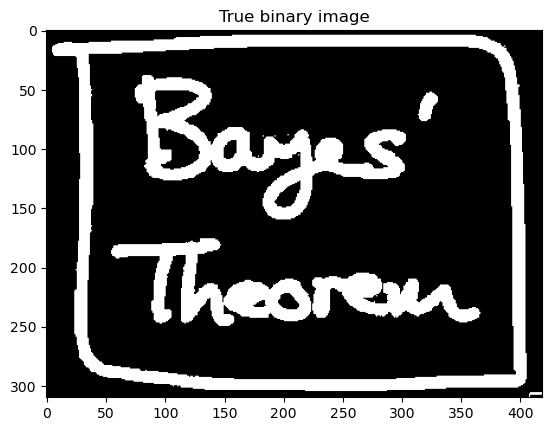

In [24]:
#load image data
data = Image.open('bayes.bmp')
temp = np.double(data)
temp_mean = np.mean(data)
clean_img = +1*(temp>temp_mean) + -1*(temp<temp_mean)

plt.figure()
plt.imshow(clean_img,cmap='Greys')
plt.title("True binary image")

310 419


Text(0.5, 1.0, 'observed noisy image')

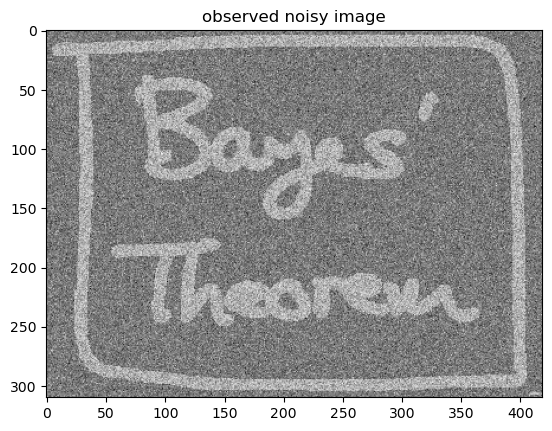

In [28]:
height,width = clean_img.shape
print(height,width)
sigma  = 1  #noise level
noisy_img = clean_img + sigma*np.random.randn(height, width)
plt.figure()
plt.imshow(noisy_img, cmap='Greys')
plt.title("observed noisy image")

Implement Gibbs sampler for Ising model presented in the lecture to denoise the image. Comapre denoised image with the original image.

Iteration - 0
Iteration - 1
Iteration - 2
Iteration - 3
Iteration - 4
Iteration - 5
Iteration - 6
Iteration - 7
Iteration - 8
Iteration - 9
Iteration - 10
Iteration - 11
Iteration - 12
Iteration - 13
Iteration - 14


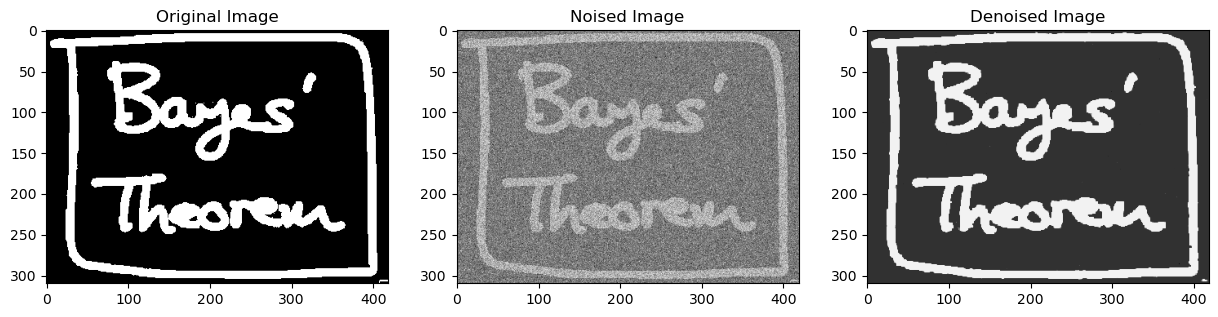

In [29]:
import random
class IsingModel:
    def __init__(self, image, ext_factor, beta):

        self.width, self.height, self.ext_factor, self.beta = image.shape[0], image.shape[1], ext_factor, beta
        self.image = image

    def neighbours(self, x, y):
        n = []
        if x == 0:
            n.append((self.width-1, y))
        else:
            n.append((x-1, y))
        if x == self.width-1:
            n.append((0, y))
        else:
            n.append((x+1, y))
        if y == 0:
            n.append((x, self.height-1))
        else:
            n.append((x, y-1))
        if y == self.height-1:
            n.append((x, 0))
        else:
            n.append((x, y+1))
        return n

    def local_energy(self, x, y):
        return self.ext_factor[x,y] + sum(self.image[xx,yy] for (xx, yy) in self.neighbours(x, y))

    def gibbs_sample(self, x, y):
        p = 1 / (1 + np.exp(-2 * self.beta * self.local_energy(x,y)))
        if random.uniform(0, 1) <= p:
            self.image[x, y] = 1
        else:
            self.image[x, y] = -1


def denoise(image, q, burn_in, iterations):
    external_factor = 0.5 * np.log(q / (1-q))
    model = IsingModel(image, external_factor*image, 3)

    avg = np.zeros_like(image).astype(np.float64)
    for i in range(burn_in + iterations):
        print("Iteration - " + str(i))
        for x in range(image.shape[0]):
            for y in range(image.shape[1]):
                if(random.uniform(0, 1) <= 0.7):
                    model.gibbs_sample(x, y)
        if(i > burn_in):
            avg += model.image
    return avg / iterations


h = 0 
beta = 1
eta = 2.1
y = noisy_img.copy()
avg = denoise(noisy_img, 0.7, 5, 10)


plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(clean_img, cmap='Greys')
plt.subplot(132)
plt.title('Noised Image')
plt.imshow(y, cmap='Greys')
plt.subplot(133)
plt.title('Denoised Image')
plt.imshow(avg, cmap='Greys')
plt.show()

Try different noise levels and plot the normalized mean squared error (NMSE) vs noise level.


Iteration - 0
Iteration - 1
Iteration - 2
Iteration - 3
Iteration - 4
Iteration - 5
Iteration - 6
Iteration - 7
Iteration - 8
Iteration - 9
Iteration - 10
Iteration - 11
Iteration - 12
Iteration - 13
Iteration - 14
Iteration - 0
Iteration - 1
Iteration - 2
Iteration - 3
Iteration - 4
Iteration - 5
Iteration - 6
Iteration - 7
Iteration - 8
Iteration - 9
Iteration - 10
Iteration - 11
Iteration - 12
Iteration - 13
Iteration - 14
Iteration - 0
Iteration - 1
Iteration - 2
Iteration - 3
Iteration - 4
Iteration - 5
Iteration - 6
Iteration - 7
Iteration - 8
Iteration - 9
Iteration - 10
Iteration - 11
Iteration - 12
Iteration - 13
Iteration - 14
Iteration - 0
Iteration - 1
Iteration - 2
Iteration - 3
Iteration - 4
Iteration - 5
Iteration - 6
Iteration - 7
Iteration - 8
Iteration - 9
Iteration - 10
Iteration - 11
Iteration - 12
Iteration - 13
Iteration - 14
Iteration - 0
Iteration - 1
Iteration - 2
Iteration - 3
Iteration - 4
Iteration - 5
Iteration - 6
Iteration - 7
Iteration - 8
Iteration - 9


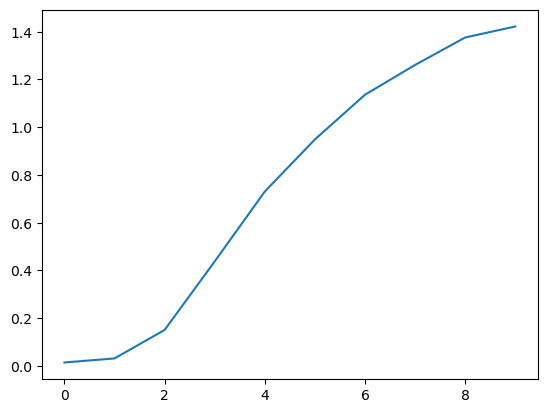

In [31]:
NMSE = lambda x: (((clean_img - x)**2).sum() / (clean_img**2).sum())**1
err = []
for sigma in range(0,10):
    noisy_img = clean_img + sigma*np.random.randn(height, width)
    denoised = denoise(noisy_img,0.7,5,10)
    err.append(NMSE(denoised))

plt.plot(err)
plt.show()

Try different parameters in the energy function, e.g., $ \beta, \eta$, and  plot the following figures.
1. NMSE vs $ \beta$
2. NMSE vs $ \eta$

C:\Users\Weilong Chen\AppData\Local\Temp\ipykernel_3156\659054230.py:40: RuntimeWarning: divide by zero encountered in log
  external_factor = 0.5 * np.log(q / (1-q))


Iteration - 0
Iteration - 1
Iteration - 2
Iteration - 3
Iteration - 4
Iteration - 5
Iteration - 6
Iteration - 7
Iteration - 8
Iteration - 9
Iteration - 10
Iteration - 11
Iteration - 12
Iteration - 13
Iteration - 14
Iteration - 0
Iteration - 1
Iteration - 2
Iteration - 3
Iteration - 4
Iteration - 5
Iteration - 6
Iteration - 7
Iteration - 8
Iteration - 9
Iteration - 10
Iteration - 11
Iteration - 12
Iteration - 13
Iteration - 14
Iteration - 0
Iteration - 1
Iteration - 2
Iteration - 3
Iteration - 4
Iteration - 5
Iteration - 6
Iteration - 7
Iteration - 8
Iteration - 9
Iteration - 10
Iteration - 11
Iteration - 12
Iteration - 13
Iteration - 14
Iteration - 0
Iteration - 1
Iteration - 2
Iteration - 3
Iteration - 4
Iteration - 5
Iteration - 6
Iteration - 7
Iteration - 8
Iteration - 9
Iteration - 10
Iteration - 11
Iteration - 12
Iteration - 13
Iteration - 14
Iteration - 0
Iteration - 1
Iteration - 2
Iteration - 3
Iteration - 4
Iteration - 5
Iteration - 6
Iteration - 7
Iteration - 8
Iteration - 9


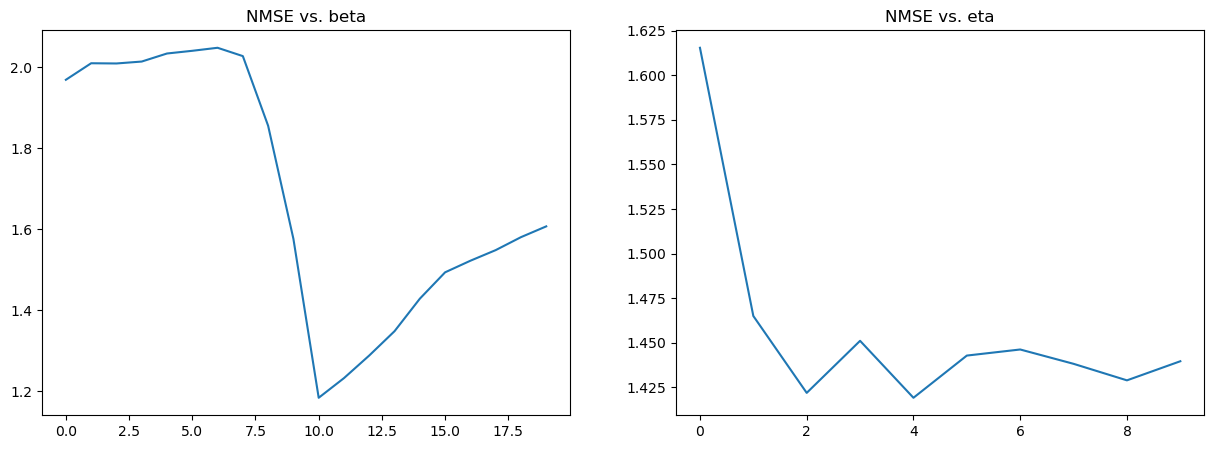

In [36]:
NMSE = lambda D: (((clean_img - D)**2).sum() / (clean_img**2).sum())**1
Beta = []
Eta = []       
for q in np.arange(0,1,0.05):
    
    noisy_img = clean_img + sigma*np.random.randn(height, width)
    denoised = denoise(noisy_img,q,5,10)
    Beta.append(NMSE(denoised))
        

for burn_in in np.arange(0,10,1):
    beta = 1
    noisy_img = clean_img + sigma*np.random.randn(height, width)
    denoised = denoise(noisy_img,0.7,burn_in,10)
    Eta.append(NMSE(denoised))

# horizontal label is the number of points    
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('NMSE vs. beta')
plt.plot(Beta)
plt.subplot(122)
plt.title('NMSE vs. eta')
plt.plot(Eta)
plt.show()

## Image denosing with Mean-field approximation

Now, we try to apply mean-field approximation to denoise the image.
The posterior for Ising model has the following form
$$P(x\mid y) = \frac{1}{Z}exp(-E(x))$$
where
$$E(x) = E_{0}(x) - \sum_{i}L_{i}(x_{i}) \;\;\;\;\;\; E_{0}(x) = - \beta\sum_{i,j}x_{i}x_{j},\;\;\;  L_{i}(x_{i}) = \eta\sum_{i}x_{i}y_{i}$$
In mean-field approximation, we try to approximate this posterior by a fully factored approximation
$$q(x) = \prod_{i}q(x_{i}, \mu_{i})$$
where $\mu_{i}$ is the mean value of node $i$. To derive the update for the variational parameter $\mu_{i}$, we
first write out $log\tilde{p}(x) = -E(x)$, dropping terms that do not involve $x_{i}$:
$$log\tilde{p}(x) = \beta x_{i} \sum_{j}x_{j} + L_{i}(x_{i}) + const$$
This only depends on the states of the neighboring nodes. Now we take expectations of this wrt
$ \prod_{j\neq i}q(x_{i})$ to get
$$q(x_{i}) \propto exp(x_{i}\sum_{j}\beta \mu_{j} + L_{i}(x_{i})) $$
Thus we replace the states of the neighbors by their average values. Let
$$ m_{i} = \sum_{j} \beta \mu_{j} $$
be the mean field influence on node $i$. Also, let $L_{i}^{+}=L_{i}(1)$ and $L_{i}^{-}=L_{i}(-1)$. The
approximate marginal posterior is given by
$$q_{i}(x_{i}=1)=\frac{exp(m_{i}+L_{i}^{+})}{exp(m_{i}+L_{i}^{+})+exp(-m_{i}+L_{i}^{-})}=sigm(2a_{i}),\;\;\;\;\;\;a_{i}=m_{i}+0.5(L_{i}^{+}-L_{i}^{-})  $$
Similarly, we have $q_{i}(x_{i}=-1) = sigm(-2a_{i})$. From this we can compute the new mean for
site $i$:
$$\mu_{i} = \mathbb{E}_{q_{i}}[x_{i}] = tanh(a_{i})$$
Hence the update equation becomes
$$\mu_{i} = \mathbb{E}_{q_{i}}[x_{i}] =q_{i}(x_{i}=+1)(+1) + q_{i}(x_{i}=-1)(-1) = tanh(a_{i})$$
Hence the update equation becomes
$$\mu_{i} = tanh(\sum_{j} \beta \mu_{j}+0.5(L_{i}^{+}-L_{i}^{-}) )$$
We can turn the above equations in to a fixed point algorithm by writing
$$\mu_{i}^{t} = tanh(\sum_{j} \beta \mu_{j}^{t-1}+0.5(L_{i}^{+}-L_{i}^{-}) )$$
It is usually better to use damped updates of the form
$$\mu_{i}^{t} = (1-\lambda)\mu_{j}^{t-1} + \lambda tanh(\sum_{j} \beta \mu_{j}^{t-1}+0.5(L_{i}^{+}-L_{i}^{-}) ) ,\;\;\;\;\;\; 0<\lambda<1$$

Write your code below to denoise the image using mean-field approximation and draw the same plots as image denoising using Gibbs sampling.

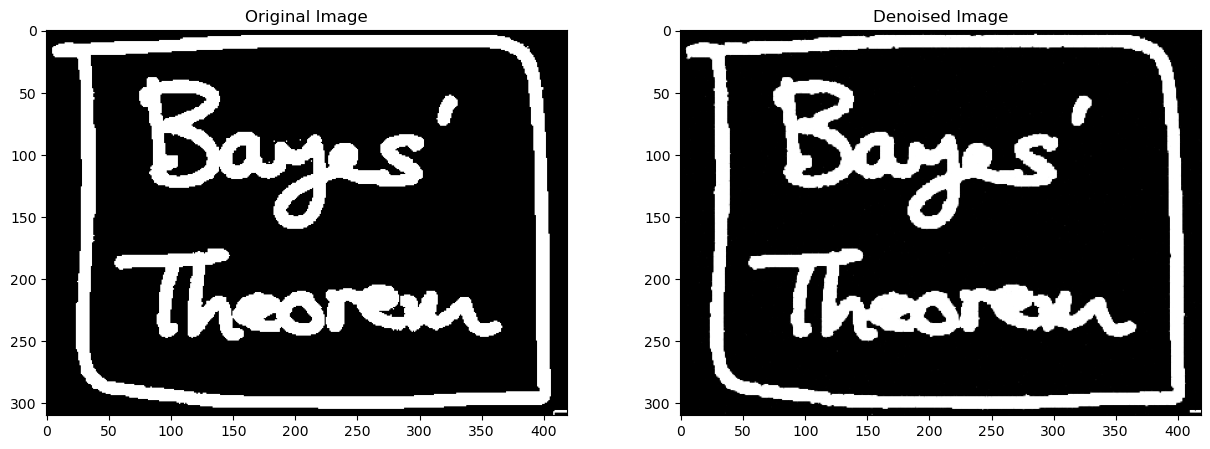

In [37]:
from scipy.stats import multivariate_normal
from scipy.special import expit as sigmoid

height, width = clean_img.shape
sigma  = 1  #noise level
y = clean_img + sigma*np.random.randn(height, width) # noisy_img
beta = 1
eta = 1
lam = 0.5  
max_iter = 20

def denoise(max_iter, y):
    Li = eta*(multivariate_normal.logpdf(y.flatten(), mean=+1, cov=1) - \
        multivariate_normal.logpdf(y.flatten(), mean=-1, cov=1))
    Li = np.reshape(Li, (height, width))
    mu = sigmoid(Li)-0.5 #init
    for i in range(max_iter):
        mu_ti = mu 
        for ix in range(width):
            for iy in range(height):
                pos = iy + height*ix
                neigh = pos + np.array([-1, 1, -height, height])            
                boundary = [iy != 0, iy != height-1, ix != 0, ix != width-1]
                neigh = neigh[np.where(boundary)[0]]            
                xx, yy = np.unravel_index(pos, (height, width), order='F')
                nx, ny = np.unravel_index(neigh, (height, width), order='F')
                Sum = beta*np.sum(mu[nx,ny])
                mu_ti[xx,yy] = (1-lam)*mu_ti[xx,yy] + lam*np.tanh(Sum + 0.5*Li[xx,yy])
                mu[xx,yy] = mu_ti[xx,yy]
    return mu

denoised2 = denoise(max_iter, y)     
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Original Image')
plt.imshow(clean_img, cmap='Greys')
plt.subplot(122)
plt.title('Denoised Image')
plt.imshow(denoised2, cmap='Greys')
plt.show()



Compare the NMSE of the denoising schemes that you have implemented here and the previous Python lab, e.g., ICM, Gibbs sampling, and mean-field approximation.

<Figure size 640x480 with 0 Axes>

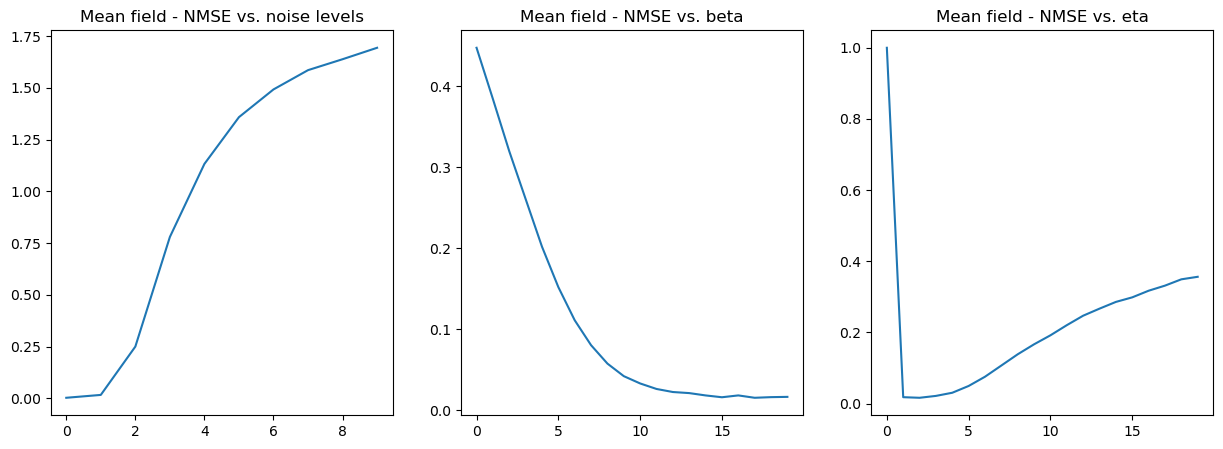

"\nplt.figure(2)\nplt.figure(figsize=(15,5))\nplt.subplot(131)\nplt.title('Gibbs - NMSE vs. noise levels')\nplt.plot(err)\nplt.subplot(132)\nplt.title('Gibbs - NMSE vs. beta')\nplt.plot(Beta)\nplt.subplot(133)\nplt.title('Gibbs - NMSE vs. eta')\nplt.plot(Eta)\nplt.show()\n"

In [38]:
# Mean field
beta = 1  
lam = 0.5  
max_iter = 20
NMSE = lambda D: (((clean_img - D)**2).sum() / (clean_img**2).sum())**1
height, width = clean_img.shape

Err2 = []
for sigma in range(0,10,1):
    y = clean_img + sigma*np.random.randn(height, width) 
    denoised2 = denoise(max_iter, y) 
    Err2.append(NMSE(denoised2))

sigma = 1
Beta2 = []        
for beta in np.arange(0,1,0.05):
    eta = 1
    y = clean_img + sigma*np.random.randn(height, width) 
    denoised2 = denoise(max_iter, y) 
    Beta2.append(NMSE(denoised2))
      
Eta2 = []
for eta in np.arange(0,10,0.5):
    beta = 1
    y = clean_img + sigma*np.random.randn(height, width) 
    denoised2 = denoise(max_iter, y) 
    Eta2.append(NMSE(denoised2))
    
plt.figure(1)
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Mean field - NMSE vs. noise levels')
plt.plot(Err2)
plt.subplot(132)
plt.title('Mean field - NMSE vs. beta')
plt.plot(Beta2)
plt.subplot(133)
plt.title('Mean field - NMSE vs. eta')
plt.plot(Eta2)
plt.show()

